# Jellium
[?](?)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

# from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA
from hnc.hnc.PIE_TwoElectron import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas, Degeneracy_Parameter, Fermi_Energy

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


### Set Parameters in Paper and Plot

In [20]:
name = 'Jellium'
Z, A = 1,1 

Te_eV = 0.00001 # eV
rs_AU = 1
rs_cm = rs_AU/cm_to_AU
ne_cc = n_from_rs(rs_cm)
ne_AU = n_from_rs(rs_AU)


#### Run Ornstein-Zernike Closure

In [21]:
# Helpful unit functions
P_hnc_to_AU   = lambda P_hnc, ri: (P_hnc/ri**3) 
P_hnc_to_bar  = lambda P_hnc, ri: P_hnc_to_AU(P_hnc, ri) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc, ri: 1e-6*P_hnc_to_bar(P_hnc, ri)
P_hnc_to_GPa  = lambda P_hnc, ri: P_hnc_to_bar(P_hnc, ri) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc, ri: E_hnc/(3/(4*π)) * AU_to_eV

P_hnc_to_AU = np.vectorize(P_hnc_to_AU)
P_hnc_to_bar = np.vectorize(P_hnc_to_bar)
P_hnc_to_Mbar = np.vectorize(P_hnc_to_Mbar)
P_hnc_to_GPa = np.vectorize(P_hnc_to_GPa)
E_hnc_to_eV = np.vectorize(E_hnc_to_eV)

def get_jellium_P_Mbar(jellium_hnc):
    # jellium_hnc.h_r_matrix -= 1
    P_hnc = jellium_hnc.excess_pressure_matrix()
    # jellium_hnc.h_r_matrix += 1
    return P_hnc_to_Mbar(P_hnc)[0,0]


In [22]:
jellium_func = lambda Te_eV, ne_cc: PLASMA(1, 1, ne_cc, 1, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Make Jellium PLASMA object
jellium = jellium_func(Te_eV, ne_cc)
jellium.run_jellium_hnc(ideal=False)



Te_in_eV: 0.000
Ti_in_eV: 1.000
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 4.101e-02
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 9.001e-09


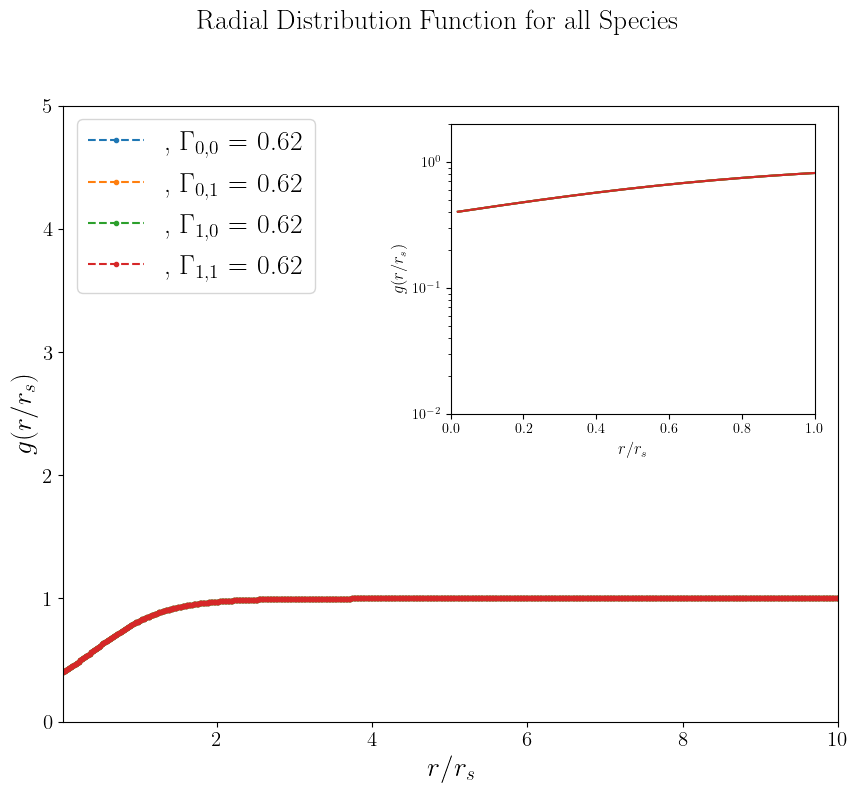

In [23]:
jellium.jellium_hnc.plot_g_all_species()

#### DW & Perrot Formula for Exc


In [24]:
from scipy.integrate import simpson, quad
    
def get_integral_for_λ(λ):
    jellium = jellium_func(Te_eV, ne_cc)
    jellium.make_jellium_hnc(ideal=False)
 
    r_array = jellium.hnc.r_array
    r = r_array*jellium.qsp.ri
    
    βv_uu_P = jellium.qsp.βv_Pauli(r_array)
    βv_ud_P = jellium.qsp.βv_Pauli(r_array)
    βv_uu = βv_uu_P + λ * (jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array))
    βv_ud = βv_ud_P + λ * (jellium.qsp.βvee(r_array) - jellium.qsp.βv_Pauli(r_array))
    
    jellium.jellium_hnc.set_βu_matrix(np.array([[  βv_uu, βv_ud  ],
            								    [  βv_ud, βv_uu  ]]))

    jellium.jellium_hnc.HNC_solve(**jellium.hnc_solve_options)
    
    
    h_uu = jellium.jellium_hnc.h_r_matrix[0,0]
    h_ud = jellium.jellium_hnc.h_r_matrix[0,1]
    
    integrand = 4*π*r**2 / r * (h_uu + h_ud)
    
    Exc_lambda = simpson(integrand,r)
    
    return Exc_lambda

def get_Exc():
    Exc_λ = lambda λ: get_integral_for_λ(λ)/2
    # integral = quad(Exc_λ, 0, 1)
    λ_array = np.linspace(0,1,num=10)
    Exc_λ = np.vectorize(Exc_λ)
    Exc_λ_array = Exc_λ(λ_array)
    return λ_array, Exc_λ_array

output = get_Exc()

Te_in_eV: 0.000
Ti_in_eV: 1.000
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 0.000e+00
Exiting status 0, reverting to best index so far: 0
Final iter:2, Total Error: 0.000e+00
Te_in_eV: 0.000
Ti_in_eV: 1.000
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 0.000e+00
Exiting status 0, reverting to best index so far: 0
Final iter:2, Total Error: 0.000e+00
Te_in_eV: 0.000
Ti_in_eV: 1.000
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 6.084e-03
Exiting status 0, reverting to best index so far: 20
Final iter:21, Total Error: 5.763e-09
Te_in_eV: 0.000
Ti_in_eV: 1.000
Warning, small T<<EF disagree with DW. Need to adjust?
Warning, setting qsp based on self βP
0: Initial condition Total Error: 1.138e-02
Exiting status 0, reverting to best index so far: 21
Fi

In [25]:
E_xc = simpson(output[1], output[0])

In [26]:
rs_AU, E_xc

(1, -2.7642062206110785)

In [30]:
-0.4582*ne_AU/rs_AU

-0.10938719238705967